Students : 
- Ghribi Saif Eddine 
- Gomez Enrique

# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [0]:
# Change here using YOUR first and last names
fn1 = "enrique"
ln1 = "gomez"
fn2 = "saifeddine"
ln2 = "ghribi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_gomez_enrique_and_ghribi_saifeddine.ipynb


Some imports

In [0]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from scipy.optimize import check_grad
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

import numba
from numba import njit
print(numba.__version__)

0.45.1


## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

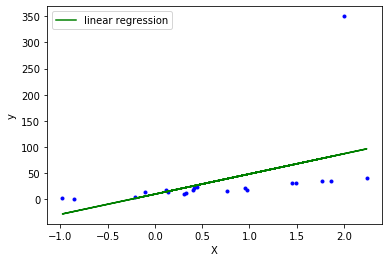

In [0]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
reg = LinearRegression()
reg.fit(X, y)

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

# QUESTION 0
Describe the issue you observe and suggest an explanation and a possible solution.
    

## Answer 
    
$\bullet$ There is an outlier which affected the regression. It makes the regression curve to go upwards and this makes the model not to follow most of the points correctly. The model is said to overfit the data. 

$\bullet$ A solution for this issue is to use Regularization that will reduce the complexity of the parameters and reduce the overfitting.

$\bullet$ To see the effect of the outlier , the following code will compare the quality of regression before and after removing the outlier.


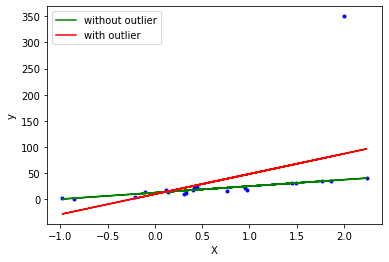

In [0]:
# Fit the model
X_out,X_temp = X.copy(),X.copy()
y_out,y_temp = y.copy(),y.copy()
X_out[0, 0] = 2.
y_out[0] = 350

X_temp[0,0]= np.mean(X[:,0])
y_temp [0] = np.mean(y)
reg1 = LinearRegression()
reg1.fit(X_out, y_out)
reg2 = LinearRegression()
reg2.fit(X_temp,y_temp)
# Visualize the model
x = X_temp[:, 0]
y_pred = reg2.coef_ * x + reg2.intercept_
x_out = X_out[:,0]
y_pred_out = reg1.coef_ * x_out + reg1.intercept_
plt.plot(x_out,y_out,'b.',c="b")
plt.plot(x, y_pred, 'g-', label="without outlier",c="g")
plt.plot(x_out,y_pred_out,'g-',label="with outlier",c="r")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

## Part 1: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [0]:
epsilon = 1.

@njit
def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z



 # QUESTION 1:
     
Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$
    


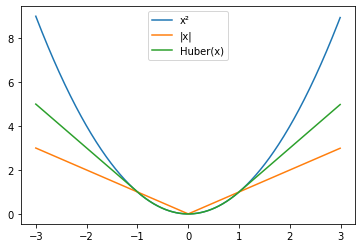

In [0]:
### TODO
x_plot = np.arange(-3,3,0.01)
plt.plot(x_plot,x_plot**2,label="x²")
plt.plot(x_plot,np.absolute(x_plot),label="|x|")
plt.plot(x_plot,huber(x_plot,1),label="Huber(x)")
plt.legend()
### END TODO

**Comments**
The Huber loss is an intermediate between the $l_2$ and the $l_1$ ones. It works quadraticly in its first part and linearly on the second one. It is nevertheless continuous and derivable. 


# QUESTION 2:
    
- Justify the convexity of the Huber function as defined above.</li>
- Justify the smoothness of the Huber function as defined above and propose a value of for the Lipschitz constant of its gradient.

## ANSWER :
Convexity : 
We notice that the huber loss is continuous.
 <br>  let  $x,y$ such that  $|x| < \epsilon$ and $ |y| < \epsilon $ and let $ t \in [0,1] $: 

$$ f(tx + (1-t) y ) = t^2 x^2 + (1-t)^2y^2 \leq t x^2 + (1-t) y^2 \leq tf(x) + (1-t) f(y) $$ 
<br> let  $x,y \in  ]-\infty,-\epsilon] \cup ] \epsilon ,   +\infty]  $and let $ t \in [0,1]$:   
$$ f(tx + (1-t) y )  = 2 \epsilon |tx + (1-t)y| - \epsilon^2 \leq t (2\epsilon|x| - \epsilon ^2) + (1-t)(2\epsilon|y| - \epsilon ^2)$$ 
(since $ ((1-t) + t) \epsilon^2 = \epsilon^2 $ )

$$  f(tx + (1-t) y )  \leq t f(x) + (1-t) f(y) $$ 
We can then conclude that Huber function is convex.


Smoothness
    
we already have : <br> 
$$
    H'_\epsilon (x) = \left\{
	\begin{aligned}
	2x& \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon sign(x) & \quad \mathrm{if} \quad |x|  \ge \epsilon\\
	\end{aligned}
    \right.
$$


<p> $\bullet$ <b>  Case Where $ \ \vert x \vert < \epsilon$ and $ \vert y \vert < \epsilon$ : </b> </p>

<p> $$ \vert H'_{\epsilon}(x) -  H'_{\epsilon}(y) \vert = \vert 2x - 2y \vert \leq 2 \vert x-y\vert$$ </p>

<p> $\bullet$ <b> Case where $ \ \vert x \vert < \epsilon$ and $  y \in $ ]-$\infty,-\epsilon$]: </b> </p>

<p> We have x > $-\epsilon$ and y $\leq$ $-\epsilon$ So , we can deduce that  
   $$ 2x - 2y \geq 2x -(-2\epsilon) \geq 0$$

<p> $\bullet$ <b> Case where  $ \ \vert x \vert < \epsilon$ and $  y \in $ [$\epsilon$,+$\infty$[: </b> </p>
 We have x < $\epsilon$ and y $\geq$ $\epsilon$ So , we can deduce that 
 $$ 2y - 2x \geq 2\epsilon 2x \geq 0 $$
 $$ \vert H'_{\epsilon}(x) -  H'_{\epsilon}(y) \vert = \vert 2x -2 \epsilon \vert \leq \vert 2x - 2y \vert \leq 2 \vert x-y\vert$$
<p>  $$ \vert H'_{\epsilon}(x) -  H'_{\epsilon}(y) \vert = \vert 2x -(-2 \epsilon) \vert \leq \vert 2x - 2y \vert \leq 2 \vert x-y\vert$$
    

<p> As x and y play symmetric roles, so dealing with second and third case only with x is sufficient </p>   
$\bullet$ Thus The Huber function is smooth and has as  Lipschitz constant of its gradient <b>2.


# QUESTION 3
     
Write a function that computes the gradient of the Huber loss.
    


**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

In [0]:
import numba
### TODO
epsilon = 1.

@njit
def grad_huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = np.empty(x.shape)
    z[mask] = 2  * x[mask] 
    z[~mask] = np.sign(x[~mask])*2 * epsilon 
    return z
### END TODO

In [0]:
#test in linear region
print (check_grad(huber,grad_huber.py_func,np.array([-5.0])))
print (check_grad(huber,grad_huber.py_func,np.array([13.0])))
#test in quadratic region 
print (check_grad(huber,grad_huber.py_func,np.array([0.1])))

0.0
0.0
1.4854595054014652e-08


## Comment
$\bullet$ The gradient is checked and the following plot describes how the Hubble loss gradient looks.

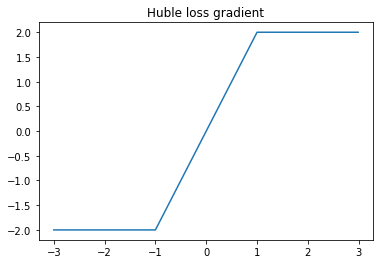

In [0]:
#let's plot the gradient
plt.title("Huble loss gradient")
plt.plot(x_plot,grad_huber.py_func(x_plot))

Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

# Question 4
     
Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above/
    


## Answer
Having that Huber loss is smooth: <br> 
    
$\bullet$ The Gradient descent is applicable for L2 norm since it's is differentiable and smooth but not applicable for L1 norm since it's not differentiable that's why we can use proximal gradient descent instead. <br>
$\bullet$ Coordinate descent is applicable for L2 norm since it's, on one hand, differentiable and smooth and, on the other hand, we can define a  Lipschitz constant for every coordinate. However it is not applicable for L1 for the same reasons of the gradient descent. <br>
$\bullet$ Both proximal gradient and coordinte descent are applicable for L1 norm and L2 since the L2 and L1 norm are prox friendly. <br>
$\bullet$ L-BFGS is applicable for L2 norm since it's smooth but not applicable for L1 norm since it's not smooth.    


# Question 5

Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    
- Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.
    
    

- The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

- To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

## Answer : Computing the gradient of the cost function 


let the cost function be : 
$$ J(w,b) = \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \sum_{j=1}^p w_j^2 $$ 
The gradient of the cost function is : 
$$ \frac{\partial J}{\partial w} = \frac{-1}{n}  \sum_{i=1}^n x_i f'(y_i - x_i^\top w - b)  + 2\lambda w$$ 
$$ \frac{\partial J}{\partial b} = \frac{-1}{n}  \sum_{i=1}^n f'(y_i - x_i^\top w - b) $$

In [0]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) \
            + lbda * np.sum(w ** 2)


def fprime(params,X=X,y=y ,lbda=lbda , epsilon=epsilon ) : 
 
    n = X.shape[0]
    # Extracting w and b from the params vector
    w= params[1:]
    b = params[0]
    grad = np.empty(params.shape)
    diff_w,diff_b = np.zeros(X.shape[1]),0  
    for i in range(n) : 
        # computing grad of J wrt w and b
        diff_w += -X[i,:] * grad_huber.py_func(y[i] -np.dot(X[i,:].T,w) - b )  
        diff_b += - grad_huber.py_func(y[i] -np.dot(X[i,:].T,w) - b ) 
    grad[1:] = (1/n)  * diff_w + 2 * lbda  * w  
    grad[0] = (1/n)  * diff_b 

    return grad   

def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    # TODO     
    n_samples, n_features = X.shape
    params_0 = np.ones(n_features+1)
    params = fmin_l_bfgs_b(pobj_l2, params_0, fprime, epsilon=epsilon, 
                           pgtol=1e-30, factr=1e-30)[0]   
    # END TODO
    return params




Cheking the gradient--->1.00245608624186e-06


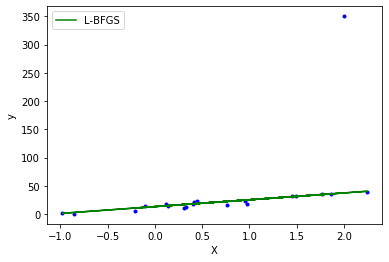

In [0]:
# TODO  (for visualization)

#checking the gradient 
chk_grad = check_grad(pobj_l2,fprime,np.array([0.5,0.3]))
print("Cheking the gradient--->" + str(chk_grad))

#Running the model 
b_hat,w_hat = huber_lbfgs_l2()
# Visualize the model
x = X[:, 0]
y_pred = w_hat* x + b_hat

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="L-BFGS")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

# END TODO

## Comments
The L2 regularization solved the problem of overfitting and the regression now is not taking into consideration the outlier.

## Part 2: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [0]:
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)

In [0]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [0]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

## Question 6
Implement the proximal gradient descent (PGD) method.

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

In [0]:
def smoothness_const_huber(A):
    """Lipschitz constant for the huber loss"""   
    l=np.linalg.norm(A,ord=2)**2
    n = np.shape(A)[0]
    # TODO
    return 2*l/n

@njit
def grad_huber_loss(params, X=X, y=y, epsilon=epsilon) : 
    """complete gradient of the Huber loss"""
    n = X.shape[0]
    w= params[1:]
    b = params[0]
    grad = params.copy() 
    prod = grad_huber(y - X.dot(w) - b,epsilon)
    grad[1:] = -  X.T.dot(prod)
    grad[0] = -  np.sum(prod)

    return grad/n

@njit
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO       
        x = prox(x - step * grad(x,grad_args[0],grad_args[1],grad_args[2]),
                 step, prox_args[0])            
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())

    return x, x_list


## QUESTION 6b
  
- Implement the L1 and L2 proximal operators. You will pay attention to the intercept.

- Using the monitor class and the plot_epochs function, display the convergence.
 

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [0]:
@njit
def prox_R2(params, reg=1.):
    """Proximal Operator for the l_2 regularization"""
    # TODO
    z = params.copy() 
    z[1:] = z[1:] / (1+ 2*reg )
    # END TODO
    return z

@njit
def prox_R1(params, reg=1.):
    """Proximal Operator for the l_2 regularization"""
    # TODO
    w = params.copy()
    w[1:] = np.sign(w[1:]) * np.maximum(np.abs(w[1:]) - reg, 0)
    return w
    # END TODO

@njit
def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)

@njit
def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

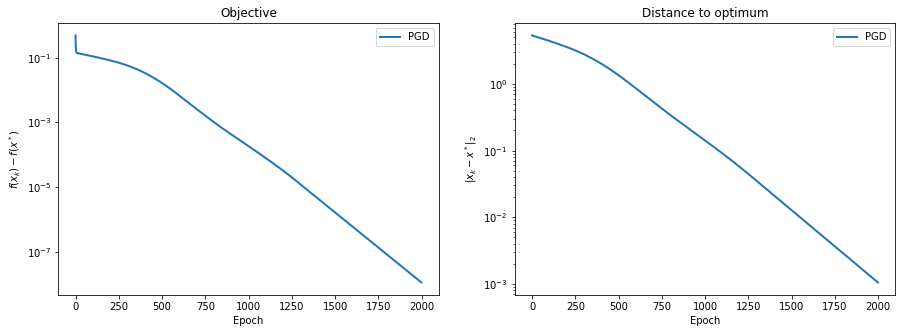

In [0]:
# Generate data
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1
epsilon = 1
step = 1/ smoothness_const_huber(X)

# TODO
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2 ,step = step, n_iter=10000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))
# END TODO


# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

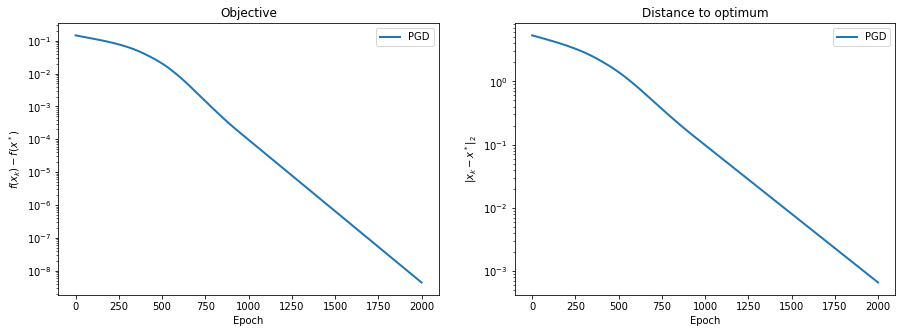

In [0]:
n_samples, n_features = X.shape

# Set initial values of parameters to optimize



x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 10.
epsilon = 1.
step = 1/ smoothness_const_huber(X)

x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step=step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))
# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

# QUESTION 7
Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.


In [0]:
@njit
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """ Accelerated proximal gradient descent algorithm.

    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.

    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        # TODO
        x_new = prox(y - step * grad(y, grad_args[0], grad_args[1], grad_args[2]),
                     step, prox_args[0])
        t_new = (1. + np.sqrt(1. + 4 * t**2))/2.
        y = x_new + (t - 1) * (x_new - x) / t_new
        t = t_new
        x = x_new
        # END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

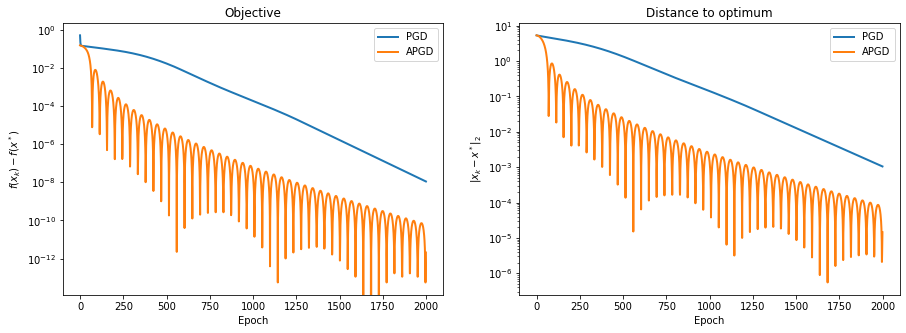

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

# TODO
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

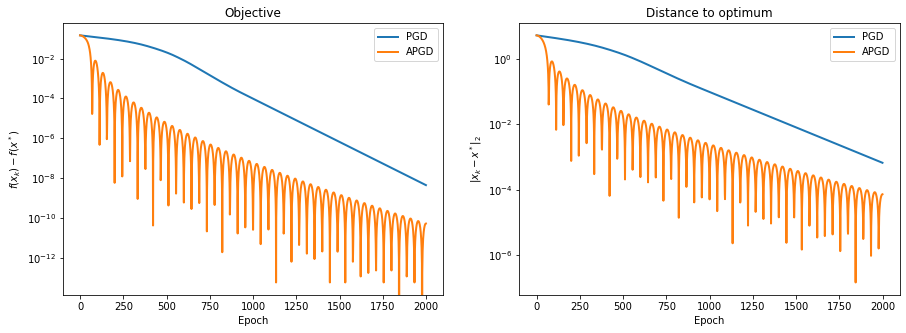

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Question 8
Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
   

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [0]:
def smoothness_const_huber_i(A):
    """Lipschitz constant for huber loss for each i"""
    n_samples, n_features = A.shape
    l = np.ones(n_features+1)  
    #lipschitz constant for b
    l[0] = 2 
    #lipchitz constant for w_i
    l[1:] =  2 * (np.linalg.norm(A,axis=0,ord=2)**2 / n_samples ) 
    return l

@njit
def grad_huber_loss_i(params, i, X=X, y=y, epsilon=epsilon):
    """Partial gradient of the Huber loss""" 
    w= params[1:]
    b = params[0]
    n = X.shape[0]
    prod = grad_huber(y - X.dot(w) - b, epsilon)/n
    if i == 0:
        return -np.sum(prod)
    else:
        return -X[:,i-1].T @ prod


@njit
def prox_l2_i(params, step, lbda):
    """Partial proximal operator with respect to a coordinate of params
    for the l2 loss"""
    arr = np.ones(2)
    arr[-1] = params
    return prox_R2(arr, reg=step * lbda)[-1]

@njit
def prox_l1_i(params, step, lbda):
    """Partial proximal operator with respect to a coordinate of params
    for the l1 loss"""
    arr = np.ones(2)
    arr[-1] = params
    return prox_R1(arr, reg=step * lbda)[-1]

In [0]:

# TODO
@njit
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """ Proximal Coordinate descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []

    n_samples, n_features = X.shape
    
    for i in range(n_iter):
        for j in range(n_features+1):
            if j == 0:        
                x[j] = x[j] - step[j] * grad(x, j, grad_args[0],
                                             grad_args[1], grad_args[2])
            else:
                x[j] = prox(x[j] - step[j] * grad(x, j, grad_args[0], 
                                                  grad_args[1], grad_args[2]),
                            step[j], prox_args[0]) 
        if i % store_every == 0:
            x_list.append(x.copy())
    
    return x, x_list



    
# END TODO

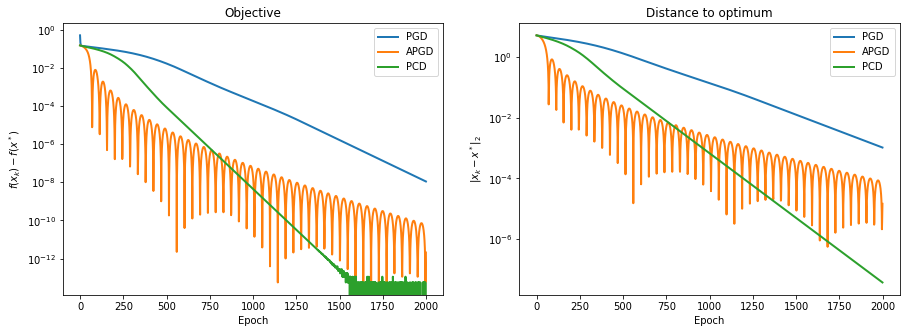

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2, step=step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

step_i = 1/smoothness_const_huber_i(X)

# TODO
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber_loss_i, prox_l2_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

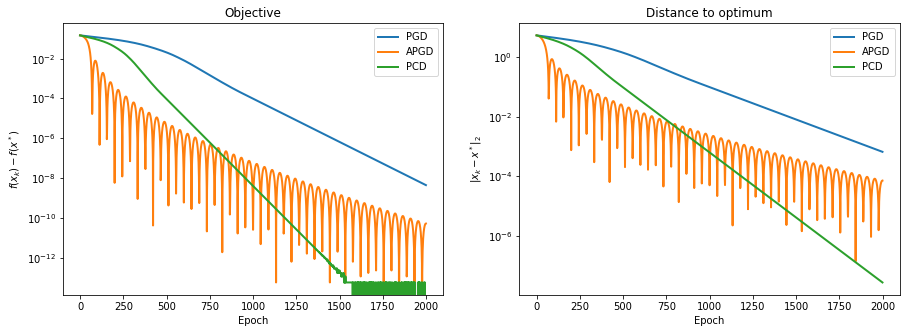

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

step_i = 1/smoothness_const_huber_i(X)

# TODO
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber_loss_i, prox_l1_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)


# QUESTION 9
    
- Compare the performance of the different solvers for different (simulated) problem sizes.


- What solver would you recommend for what problem and using what regularization?


Case 1: $n_{samples} > n_{features}$ 


In [0]:
# Generate bigger data
X, y = make_regression(n_samples=1500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
pcd.recompile()

n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.ones(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1e-2
epsilon = 1

step = 1/ smoothness_const_huber(X)
step_i = 1/smoothness_const_huber_i(X)

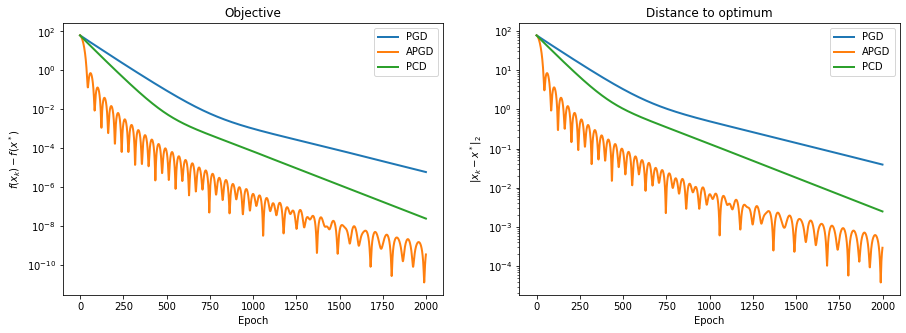

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber_loss_i, prox_l2_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

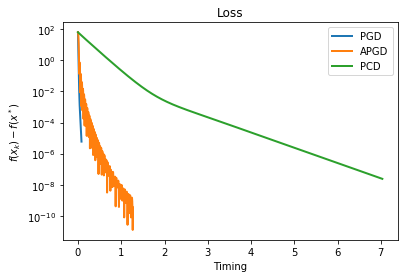

In [0]:
plot_time(monitors, solvers)

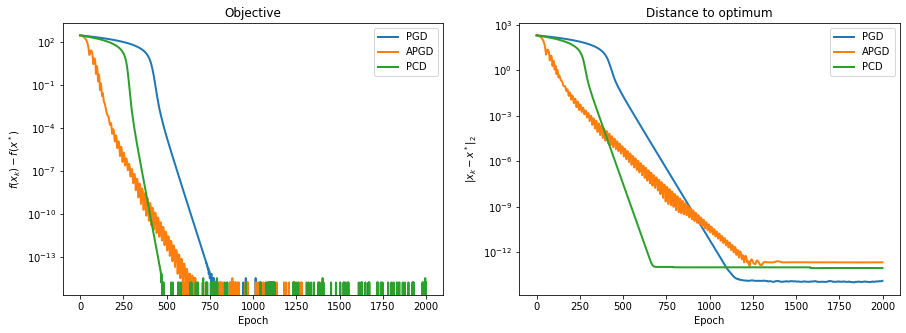

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber_loss_i, prox_l1_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)


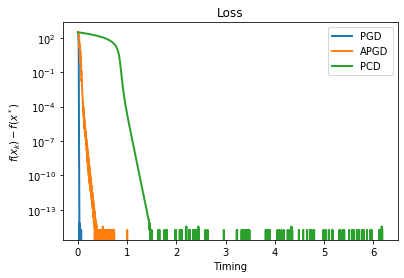

In [0]:
plot_time(monitors, solvers)

 Case 2: $n_{samples} \approx n_{features}$ 


In [0]:
# Generate bigger data
X, y = make_regression(n_samples=750, n_features=700, random_state=0,
                       noise=4.0, bias=10.0)

pcd.recompile()

n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.ones(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1e-2
epsilon = 1

step = 1/ smoothness_const_huber(X)
step_i = 1/smoothness_const_huber_i(X)

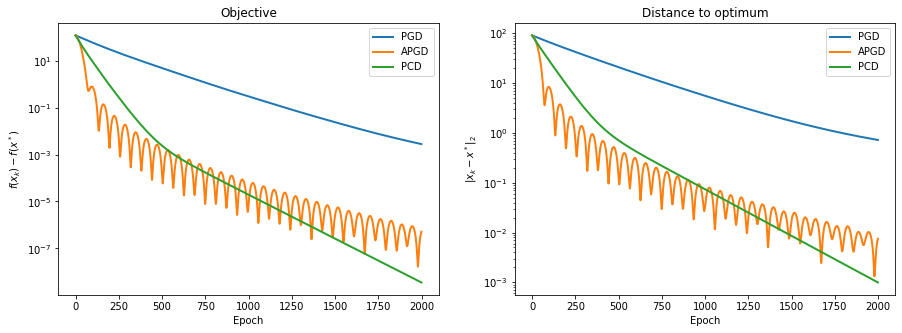

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber_loss_i, prox_l2_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

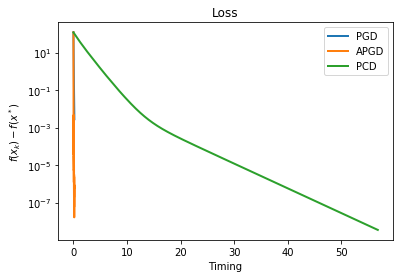

In [0]:
plot_time(monitors, solvers)

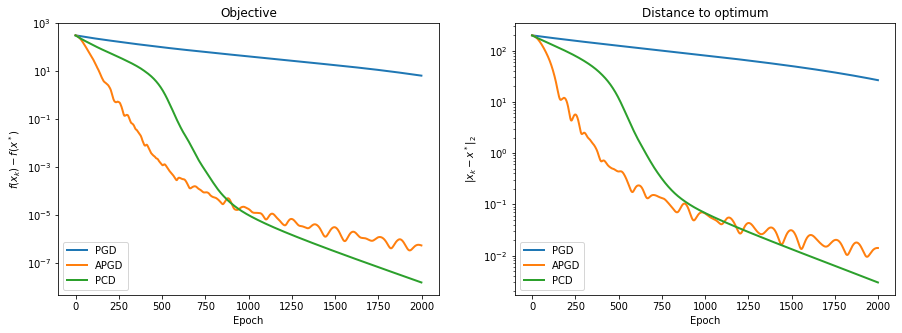

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber_loss_i, prox_l1_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

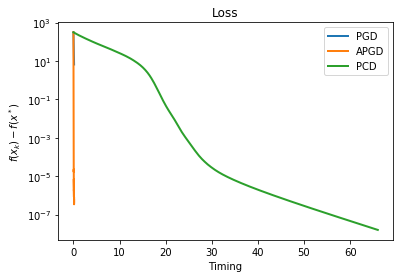

In [0]:
plot_time(monitors, solvers)

The plots are as those of case 1. However the precision of all methods got worse.

 Case 3: $n_{samples} < n_{features}$


In [0]:
# Generate bigger data
X, y = make_regression(n_samples=300, n_features=600, random_state=0,
                       noise=4.0, bias=10.0)
## Recompile the functions when changing drastically the dimensions of X
pcd.recompile()

n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.ones(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1e-2
epsilon = 1

step = 1/ smoothness_const_huber(X)
step_i = 1/smoothness_const_huber_i(X)

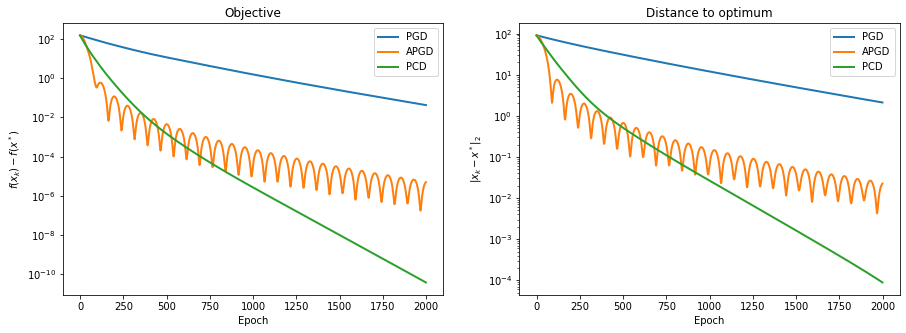

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber_loss_i, prox_l2_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

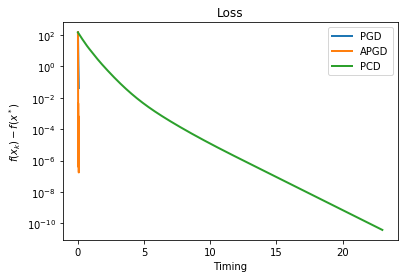

In [0]:
plot_time(monitors, solvers)

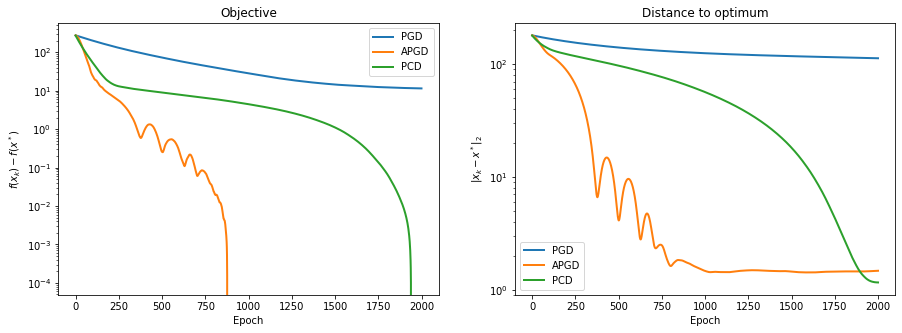

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber_loss_i, prox_l1_i, step_i, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

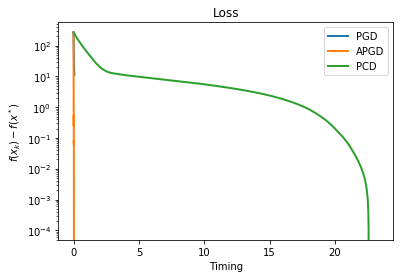

In [0]:
plot_time(monitors, solvers)

## Comments 

- In general, PCD outperforms the other methods in the long run in terms of convergence speed. However, APGD is quicker and gets better approximations in the very first iterations for both regularizations. It has indeed a really quick descent at beginning. APGD is bumpier and more unstable(has oscilliations), specially when $n_{features}$ is close or greater than $n_{samples}$. When the convergence is reached, APGD and PCD get  nearly the same precision. PGD gets slowly but surely the best precision as represented by the case 1.

- However, in the first case ( $n_{features} $ <<  $n_{samples} $ and $l_2$ regularization), APGD gets better and faster convergence that PCD. So when data is not sparsed, it would be better to use the former method.

- In terms of timing, the PCD is slower than the other methods. In fact, they use really efficient matrix multiplication using `c++` libraries as `numpy` and `scipy` for computing the gradients. Even when using `numba`, the computation of the $n$ gradients per epoch of PCD is not that efficient.

- The performance of the optimization methods is greatly influenced by the ratio of $n_{features}  $ and  $n_{samples} $.The  More the number of features get closer to the number of samples, more iterations are needed to get a good enough minimizer.



## Recommendations 
- It would be better to use PCD and $l_1$ in every configuration where `n_features < n_data ` because it is quicker and the optimum value is good enough.However, When $n_{features} $ <<  $n_{samples} $ and data is not sparse, it is better to use APGD with $l_2$ regularization.

- When $n_{features} $ > $n_{samples} $, it is not recommended to use a $l_1$ regularization as it gives unreliable results.

- When we want a not-so-precise optimum in a limited quantity of time, APGD will give the best tradeoff. Otherwise, PCD should be applied.

# Part 3: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [0]:
import pandas as pd
colab  = False 
if colab : 
    from google.colab import drive
    drive.mount('/content/drive')
    #%cd /content/drive/My\ Drive/Colab\ Notebooks/OPTIM

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [0]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx'].values
X.shape, y.shape


((8088, 2), (8088,))

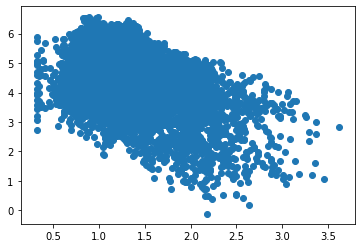

In [0]:
pgd.recompile()
apgd.recompile()
pcd.recompile()

plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.


# QUESTION 9
   
Implement the `fit` method from the estimator in the next cell
    

In [0]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y) 

        if  self.penalty == 'l1':
            if self.solver == 'pcd':
                solv = pcd
                grad = grad_huber_loss_i
                step = 1/smoothness_const_huber_i(X)
                prox = prox_l1_i
            else:
                grad = grad_huber_loss
                step = 1/smoothness_const_huber(X)
                prox = prox_l1
                if self.solver == 'pgd': solv = pgd
                elif self.solver == 'apgd': solv = apgd

        elif  self.penalty == 'l2':
            if self.solver == 'pcd':
                solv = pcd
                grad = grad_huber_loss_i
                step = 1/smoothness_const_huber_i(X)
                prox = prox_l2_i
            else:
                grad = grad_huber_loss
                step = 1/smoothness_const_huber(X)
                prox = prox_l2
                if self.solver == 'pgd': solv = pgd
                elif self.solver == 'apgd': solv = apgd

        x, _ = solv(x_init, grad, prox, step=step, n_iter=self.max_iter, 
                    grad_args=(X,y,self.epsilon), prox_args=(self.lbda,))
        

        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   MAE : 0.62260
Solver with L2: apgd   	-   MAE : 0.57340
Solver with L2: pcd   	-   MAE : 0.57371
Solver with L1: pgd   	-   MAE : 0.71309
Solver with L1: apgd   	-   MAE : 0.71309
Solver with L1: pcd   	-   MAE : 0.71309



<b>QUESTION 10:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [0]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score



# TODO
to_plot = dict()

lambdas = [0.25, 1, 1.5]
space = np.logspace(-3, 2, 7)

for lbda in lambdas:
    to_plot[lbda] = dict()
    

    ##############
    score_H_l2 = []
    for eps in space:
        clf_h_l2 = HuberRegressor(lbda=lbda, penalty='l2', max_iter=2000, 
                                epsilon=eps, solver='pcd')
        score_Huber_l2 = cross_val_score(clf_h_l2, X, y, cv=8,
                                        scoring='neg_mean_absolute_error')
        score_H_l2.append(score_Huber_l2.mean())
    
    
    ##############
    clf_ridge = Ridge(alpha=lbda*X.shape[0], tol=0.00001, max_iter=2000)
    score_Ridge = cross_val_score(clf_ridge, X, y, cv=8,
                                    scoring='neg_mean_absolute_error')
    
    
    ##############
    score_H_l1 = []
    for eps in space:
        clf_h_l1 = HuberRegressor(lbda=lbda, penalty='l1', max_iter=2000,
                                epsilon=eps, solver='pcd')
        score_Huber_l1 = cross_val_score(clf_h_l1, X, y, cv=8,
                                        scoring='neg_mean_absolute_error')
        score_H_l1.append(score_Huber_l1.mean())

    ##############
    clf_lasso = Lasso(alpha=lbda*0.5, tol=0.00001, max_iter=2000)
    score_Lasso = cross_val_score(clf_lasso, X, y, cv=8,
                                    scoring='neg_mean_absolute_error')
    
    
    to_plot[lbda]['Huber L2'] = score_H_l2
    to_plot[lbda]['Ridge'] = score_Ridge
    to_plot[lbda]['Huber L1'] = score_H_l1
    to_plot[lbda]['Lasso'] = score_Lasso


# END TODO

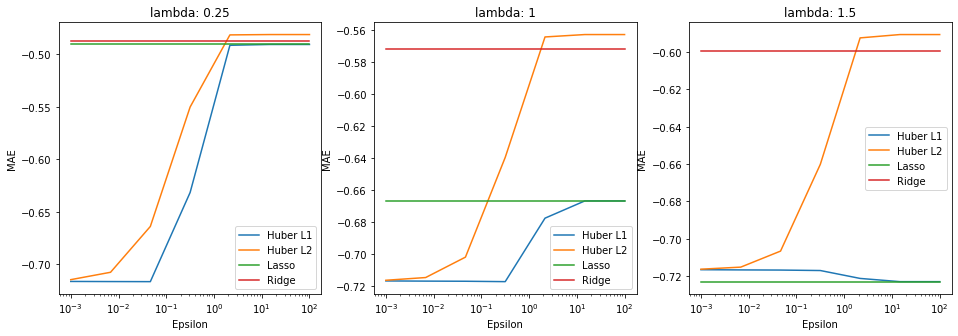

In [0]:
fig, axs = plt.subplots(1,3, figsize=(16, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)

axs = axs.ravel()

for i in range(3):
    legends = []

    axs[i].plot(space,to_plot[lambdas[i]]['Huber L1'])
    axs[i].plot(space,to_plot[lambdas[i]]['Huber L2'])
    axs[i].plot(space,
                np.ones(len(space)) * to_plot[lambdas[i]]['Lasso'].mean())
    axs[i].plot(space,
                np.ones(len(space)) * to_plot[lambdas[i]]['Ridge'].mean())

    axs[i].set_xscale("log")
    axs[i].set_xlabel("Epsilon")
    axs[i].set_ylabel("MAE")
    axs[i].legend(['Huber L1','Huber L2','Lasso','Ridge'],loc='best')
    axs[i].set_title("lambda: "+str(lambdas[i]))

plt.show()

## Comments 

- It's clear from the plots that the Huber L2 Regressor gets the better score for a high epsilon(the less negative) among all the estimators. The second to the best is the Ridge estimator. We can conclude that the best regularisation for this problem is the $l_2$. The Huber $l_1$ regressor and the Lasso get poor results.

- As the data is not sparse, the Lasso does not have a good performance aswell as the Huber loss when using a $l_1$ regularisation.

-  Finally, the smallest the value of `lambda`, the more the estimator behaves like a ordinary least squares. That is why the Lasso performs good enough on the first graph and all the regressors are good enough for a good enough lambda.

In [0]:
# Comparison between Huber l2 and Ridge
n_samples, n_features = X.shape

space = np.logspace(-5, 2, 10)
weights_h = []
lbda = 1
fctr = 1/n_samples ** 0.5

clf_ridge = Ridge(alpha=lbda, tol=0.00001, max_iter=5000)
clf_ridge.fit(X * fctr, y * fctr)

ref = np.empty(n_features + 1)
ref[0] = clf_ridge.intercept_
ref[1:] = clf_ridge.coef_


for eps in space:
    clf_h_l2 = HuberRegressor(lbda=lbda, penalty='l2', max_iter=5000, 
                              epsilon=eps, solver='pcd')
    clf_h_l2.fit(X,y)
    weights = np.empty(n_features + 1)
    weights[0] = clf_h_l2.intercept_
    weights[1:] = clf_h_l2.coef_
    weights_h.append(weights)

weights_h = np.array(weights_h)

<function matplotlib.pyplot.show(*args, **kw)>

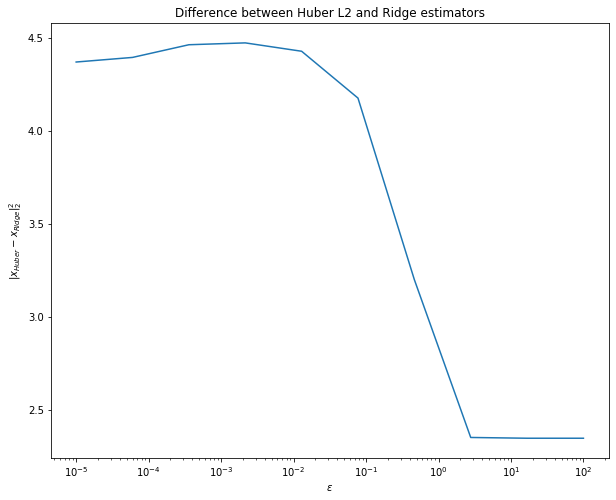

In [0]:

plt.figure(figsize=(10, 8))
plt.plot(space, linalg.norm(weights_h - ref, ord=2, axis=1))
plt.xscale("log")
plt.xlabel("$\epsilon$")
plt.ylabel("$\|x_{Huber} - x_{Ridge}\|_2^2$")
plt.title("Difference between Huber L2 and Ridge estimators")
plt.show

Comments

- The graph shows the quadratic difference between $w_{Ridge}$ and $w_{Huber-L_2}$. It is clear that the bigger the value of $\epsilon$, the smallest the difference between those to values. In fact, $\epsilon$ determines the zone where the Huber loss behaves as a quadratic loss. Therefore, this zone is bigger for higher values of $\epsilon$. 

- Then, as the data is between $[0;6]$, it is all covered by the quadratic behavior when $\epsilon$ is bigger than 6.

Time analysis

In [0]:
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.ones(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 3000
lbda = 15
epsilon = 1

step = 1/ smoothness_const_huber(X)
step_i = 1/smoothness_const_huber_i(X)

Wall time: 661 ms
Wall time: 2 s
Wall time: 3.01 s


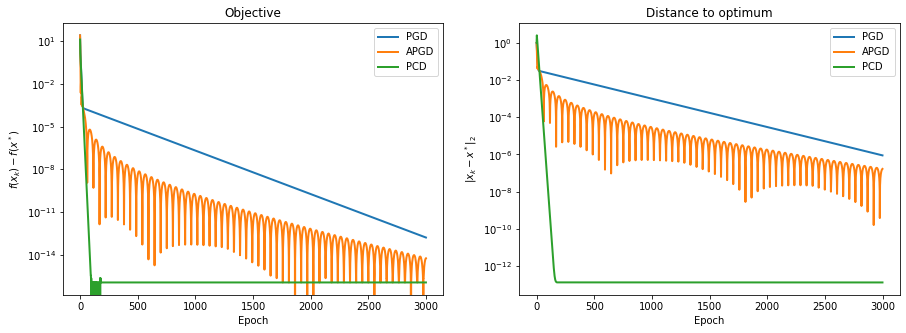

In [0]:
x_min ,_= pgd(x_init, grad_huber_loss, prox_l2, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
%time monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,\
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
%time monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,\
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
%time monitor_pcd_l2.run(x_init, grad_huber_loss_i, prox_l2_i, step_i, n_iter,\
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

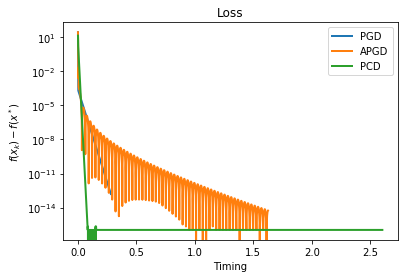

In [0]:
plot_time(monitors, solvers)

Wall time: 695 ms
Wall time: 2.17 s
Wall time: 2.78 s


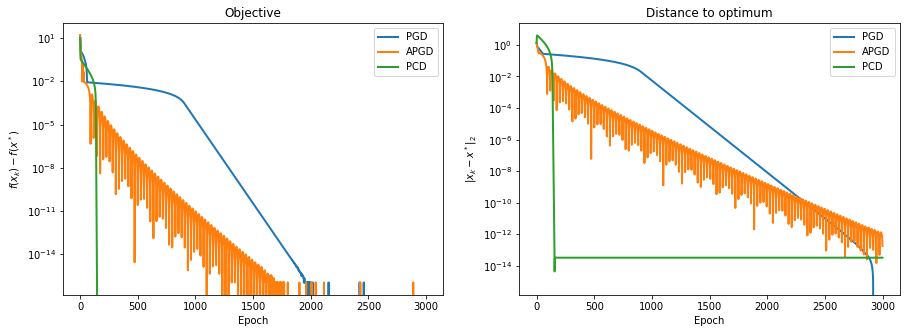

In [0]:
lbda = 1.1

x_min ,_= pgd(x_init, grad_huber_loss, prox_l1, step = step, n_iter=20000,
              grad_args=(X, y, epsilon), prox_args=(lbda,))

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
%time monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,\
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
%time monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,\
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
%time monitor_pcd_l1.run(x_init, grad_huber_loss_i, prox_l1_i, step_i, n_iter,\
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

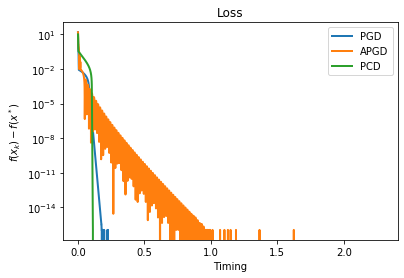

In [0]:
plot_time(monitors, solvers)

Comments 

- Opposing the results from the previous part, PCD's performance is much better than the other two solvers in both $l_1$ and $l_2$. In fact, the former converges to its optimum value in much less epochs (less than 400) and in less time. Although this relation could be seen as obvious, it is not. In fact, the algorithms have a different runtime (between 2 and 4 seconds) having the same constant value of epochs, which leads to different time per epoch. 

- PCD is the one with more time per epoch due to optimization duties. In fact, PGD and PGCD relies on numpy matrix multiplication which is already optimized in `C++`. Although we use `numba`, our implementation is not as optimized as the other.

- However, the graphs show that PCD converges much quicker in terms of epochs and time despite having a longer runtime. Then APGD and PGD have almost the same performance, with the latter having taken a little more time, as it should be.